In [529]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
%matplotlib inline 

from pandas.io.json import json_normalize
import json

from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import LogisticRegression

import folium

import itertools

# Exploring Dataset

## Sales

In [11]:
sales = pd.read_csv('..\UseCase_3_Datasets\sales_granular.csv')
sales.head()

,store_code,8/3/15 9:00,8/3/15 10:00,8/3/15 11:00,8/3/15 12:00,8/3/15 13:00,8/3/15 14:00,8/3/15 15:00,8/3/15 16:00,8/3/15 17:00,...,6/25/17 13:00,6/25/17 14:00,6/25/17 15:00,6/25/17 16:00,6/25/17 17:00,6/25/17 18:00,6/25/17 19:00,6/25/17 20:00,6/25/17 21:00,6/25/17 22:00
0,10055,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,10077,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,10079,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,10081,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,30.0,60.0,150.0,600.0,NaN,NaN,NaN
4,10085,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### Store code should be unique

In [12]:
sales.store_code.is_unique

False

In [13]:
for index, boolean in enumerate(sales.store_code.duplicated()):
    if boolean: print index

33
34
35


In [14]:
# inspect duplicate
sales.loc[sales.store_code == sales.store_code[33]]

,store_code,8/3/15 9:00,8/3/15 10:00,8/3/15 11:00,8/3/15 12:00,8/3/15 13:00,8/3/15 14:00,8/3/15 15:00,8/3/15 16:00,8/3/15 17:00,...,6/25/17 13:00,6/25/17 14:00,6/25/17 15:00,6/25/17 16:00,6/25/17 17:00,6/25/17 18:00,6/25/17 19:00,6/25/17 20:00,6/25/17 21:00,6/25/17 22:00
32,11028,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,30.0,90.0,NaN,NaN,NaN,NaN,NaN,NaN
33,11028,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,30.0,90.0,NaN,NaN,NaN,NaN,NaN,NaN
34,11028,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,30.0,90.0,NaN,NaN,NaN,NaN,NaN,NaN
35,11028,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,30.0,90.0,NaN,NaN,NaN,NaN,NaN,NaN


It seems that the 11028th POS entries have been duplicated

In [15]:
sales.drop_duplicates('store_code', inplace=True, keep='first')

In [16]:
sales.store_code.is_unique

True

# Performance Measure
We want to maximize sales and so we need to determine what is a good measure to separate good POS from bad and average POS

In [17]:
sales.head()

,store_code,8/3/15 9:00,8/3/15 10:00,8/3/15 11:00,8/3/15 12:00,8/3/15 13:00,8/3/15 14:00,8/3/15 15:00,8/3/15 16:00,8/3/15 17:00,...,6/25/17 13:00,6/25/17 14:00,6/25/17 15:00,6/25/17 16:00,6/25/17 17:00,6/25/17 18:00,6/25/17 19:00,6/25/17 20:00,6/25/17 21:00,6/25/17 22:00
0,10055,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,10077,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,10079,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,10081,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,30.0,60.0,150.0,600.0,NaN,NaN,NaN
4,10085,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [18]:
sales= sales.set_index('store_code').T.copy().fillna(0)
sales.head()

store_code,10055,10077,10079,10081,10085,10086,10111,10176,10377,10384,...,84089,84125,84128,84146,84219,84223,84351,84608,84658,85011
8/3/15 9:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,300.0,0.0,0.0,0.0,0.0,0.0,0.0
8/3/15 10:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,600.0,0.0,0.0,0.0,0.0,0.0,0.0
8/3/15 11:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8/3/15 12:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8/3/15 13:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [19]:
sales= sales.T
sales.head()sales = (sales - (sales.shift(periods=1, axis=0).fillna(0)))
sales.head()

store_code,10055,10077,10079,10081,10085,10086,10111,10176,10377,10384,...,84089,84125,84128,84146,84219,84223,84351,84608,84658,85011
8/3/15 9:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,300.0,0.0,0.0,0.0,0.0,0.0,0.0
8/3/15 10:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,300.0,0.0,0.0,0.0,0.0,0.0,0.0
8/3/15 11:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,-600.0,0.0,0.0,0.0,0.0,0.0,0.0
8/3/15 12:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8/3/15 13:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [20]:
sales= sales.T
sales.head()

,8/3/15 9:00,8/3/15 10:00,8/3/15 11:00,8/3/15 12:00,8/3/15 13:00,8/3/15 14:00,8/3/15 15:00,8/3/15 16:00,8/3/15 17:00,8/3/15 18:00,...,6/25/17 13:00,6/25/17 14:00,6/25/17 15:00,6/25/17 16:00,6/25/17 17:00,6/25/17 18:00,6/25/17 19:00,6/25/17 20:00,6/25/17 21:00,6/25/17 22:00
store_code,,,,,,,,,,,,,,,,,,,,,
10055,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10077,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10079,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10081,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-60.0,0.0,0.0,30.0,30.0,90.0,450.0,-600.0,0.0,0.0
10085,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [22]:
sales_perf = (sales.sum(axis=1)/(sales != 0).sum(axis=1)).to_frame()
sales_perf.columns = ['Mean_Perf']

In [23]:
sales_perf['Median_Perf'] = sales[sales!=0].median(axis=1)

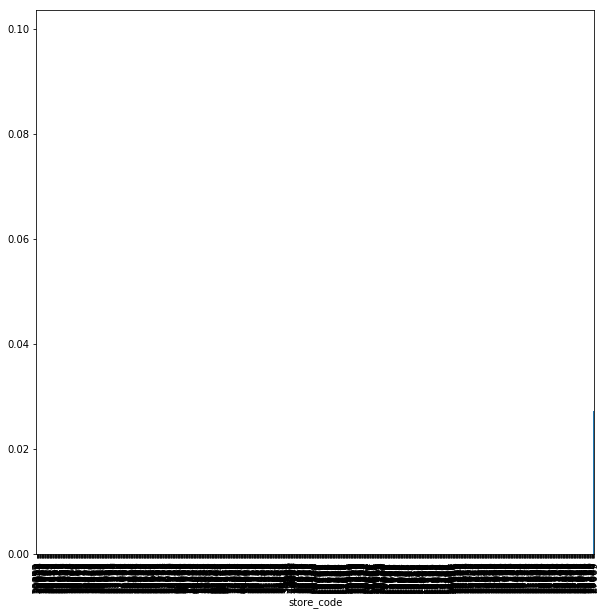

In [25]:
sales_perf.Mean_Perf.sort_values().plot.bar(figsize=(10,10))

Mean of differences does not allow us to create classes for modelling

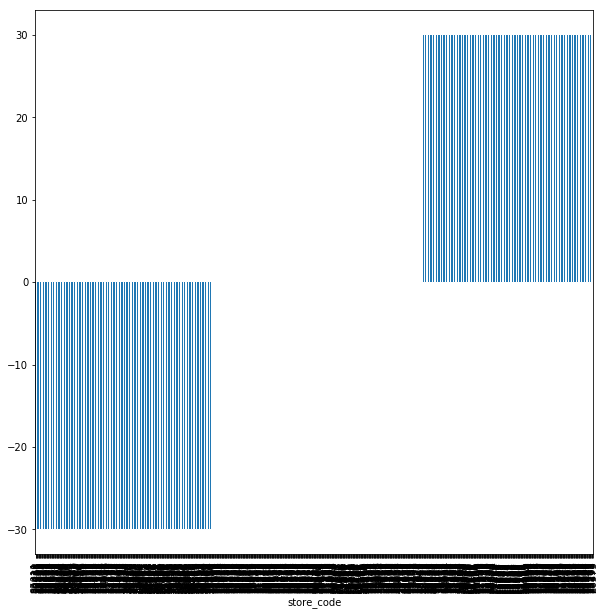

In [26]:
sales_perf.Median_Perf.sort_values().plot.bar(figsize=(10,10))

In [27]:
sales_perf.Median_Perf.value_counts()

 0.0     340
-30.0    284
 30.0    279
Name: Median_Perf, dtype: int64

While the median of the difference createa very good separation between good, average and bad POS. Indeed, the median is outlier resistant and the examination of the sales' time serie revealed the presence of outliers in the dataset.

In [28]:
sales_perf.head()

,Mean_Perf,Median_Perf
store_code,,
10055,0.0,30.0
10077,0.0,30.0
10079,0.0,30.0
10081,0.0,-30.0
10085,0.0,-30.0


# Grouping POS On Performance

In [29]:
def group_perfs(x):
    if x < 0 :
        return -1
    elif x == 0 :
        return 0
    return 1

sales_perf['Performance'] = sales_perf.Median_Perf.apply(group_perfs)
sales_perf.head()

,Mean_Perf,Median_Perf,Performance
store_code,,,
10055,0.0,30.0,1
10077,0.0,30.0,1
10079,0.0,30.0,1
10081,0.0,-30.0,-1
10085,0.0,-30.0,-1


We have a really good repartition of the performance, i.e we will not have a problem of class-imbalance for modelling
# Surroundings

In [31]:
d = json.load(open('..\UseCase_3_Datasets\Surroundings.json'))

In [32]:
surroundings = json_normalize(d)

In [33]:
surroundings.set_index('store_code', inplace=True)
surroundings.head()

,surroundings.accounting,surroundings.airport,surroundings.amusement_park,surroundings.aquarium,surroundings.art_gallery,surroundings.atm,surroundings.bakery,surroundings.bank,surroundings.bar,surroundings.beauty_salon,...,surroundings.store,surroundings.subway_station,surroundings.synagogue,surroundings.taxi_stand,surroundings.train_station,surroundings.transit_station,surroundings.travel_agency,surroundings.university,surroundings.veterinary_care,surroundings.zoo
store_code,,,,,,,,,,,,,,,,,,,,,
10055,[{u'name': u'Fiduciaire Exacte & Gestion Compt...,[],[],[],"[{u'website': u'http://www.onegeeinfog.com/', ...",[{u'website': u'https://www.ubs.com/ch/fr.html...,"[{u'name': u'Mconseils SA', u'place_id': u'ChI...","[{u'website': u'http://www.ubs.ch/', u'rating'...","[{u'rating': 3.5, u'place_id': u'ChIJ8xHdm_1vj...","[{u'website': u'http://www.jadebeaute.com/', u...",...,[{u'website': u'https://filialen.migros.ch/de/...,[],[],[],[],"[{u'name': u'Chêne-Bourg, La Mousse', u'place_...","[{u'name': u'Courir au Népal Sàrl', u'place_id...",[],[{u'website': u'http://www.vet-chene-bougeries...,[]
10077,[],[],[],[],[],[],"[{u'rating': 4.8, u'place_id': u'ChIJM8FbQe9vj...",[],[],[],...,[{u'website': u'http://www.coop.ch/fr/services...,[],[],[],[],"[{u'name': u'Chêne-Bougeries, Montagne', u'pla...",[],[],[],[]
10079,[{u'website': u'http://www.vd.ch/autorites/dep...,[],[],[],[],"[{u'name': u'PickPost-Stelle', u'opening_hours...",[{u'website': u'https://filialen.migros.ch/de/...,[{u'website': u'https://www.ubs.com/ch/fr.html...,[{u'website': u'https://www.facebook.com/Highl...,"[{u'rating': 5, u'place_id': u'ChIJmxg6U4LPjUc...",...,"[{u'website': u'http://www.denner.ch/', u'rati...",[],[],[],[],"[{u'name': u'Yverdon-les-Bains, Bel-Air', u'pl...","[{u'website': u'http://www.hotelplan.ch/FR/', ...",[],[],[]
10086,[],[],[],[],[],[],[],[],"[{u'website': u'http://www.oubangui.com/', u'r...",[{u'website': u'http://www.blattnerpodologue.c...,...,"[{u'rating': 3.3, u'place_id': u'ChIJUW-HLeAxj...",[],[],[],[],"[{u'name': u'Bois-Gentil', u'place_id': u'ChIJ...",[],[],[],[]
10111,[],[],[],[],[],[],[],[],[],[],...,"[{u'name': u'lookemontre.com', u'opening_hours...",[],[],[],[],"[{u'name': u'Yverdon-les-Bains, Plaisance', u'...",[],[],[],[]


#### Store code should be unique

In [34]:
surroundings.index.is_unique

False

In [35]:
for index, boolean in enumerate(surroundings.index.duplicated()):
    if boolean: print index

21


In [36]:
surroundings.iloc[21].name

11028

In [37]:
for index, shopCode in enumerate(surroundings.index):
    if shopCode == 11028:
        print surroundings

                                      surroundings.accounting  \
store_code                                                      
10055       [{u'name': u'Fiduciaire Exacte & Gestion Compt...   
10077                                                      []   
10079       [{u'website': u'http://www.vd.ch/autorites/dep...   
10086                                                      []   
10111                                                      []   
10377       [{u'website': u'http://www.cgiconseils.ch/', u...   
10441       [{u'website': u'https://www.jffiduciaire.ch/',...   
10545       [{u'website': u'http://www.fiva.ch/', u'name':...   
10548       [{u'website': u'http://www.fiva.ch/', u'name':...   
10672                                                      []   
10814                                                      []   
10820                                                      []   
10871                                                      []   
10883       [{u'website':

                                      surroundings.accounting  \
store_code                                                      
10055       [{u'name': u'Fiduciaire Exacte & Gestion Compt...   
10077                                                      []   
10079       [{u'website': u'http://www.vd.ch/autorites/dep...   
10086                                                      []   
10111                                                      []   
10377       [{u'website': u'http://www.cgiconseils.ch/', u...   
10441       [{u'website': u'https://www.jffiduciaire.ch/',...   
10545       [{u'website': u'http://www.fiva.ch/', u'name':...   
10548       [{u'website': u'http://www.fiva.ch/', u'name':...   
10672                                                      []   
10814                                                      []   
10820                                                      []   
10871                                                      []   
10883       [{u'website':

No way to guess which of the information is correct, so we will delete the row 21

In [38]:
surroundings.drop(surroundings.index[21], inplace=True)
surroundings.index.is_unique

True

#### Delete POS with no surrounding information

In [39]:
count = surroundings.applymap(len).copy()
count.head()

,surroundings.accounting,surroundings.airport,surroundings.amusement_park,surroundings.aquarium,surroundings.art_gallery,surroundings.atm,surroundings.bakery,surroundings.bank,surroundings.bar,surroundings.beauty_salon,...,surroundings.store,surroundings.subway_station,surroundings.synagogue,surroundings.taxi_stand,surroundings.train_station,surroundings.transit_station,surroundings.travel_agency,surroundings.university,surroundings.veterinary_care,surroundings.zoo
store_code,,,,,,,,,,,,,,,,,,,,,
10055,3,0,0,0,1,1,3,3,1,4,...,31,0,0,0,0,2,1,0,1,0
10077,0,0,0,0,0,0,1,0,0,0,...,6,0,0,0,0,1,0,0,0,0
10079,1,0,0,0,0,3,3,1,4,4,...,53,0,0,0,0,4,2,0,0,0
10086,0,0,0,0,0,0,0,0,1,2,...,3,0,0,0,0,1,0,0,0,0
10111,0,0,0,0,0,0,0,0,0,0,...,2,0,0,0,0,4,0,0,0,0


In [40]:
count['summation'] = count.sum(axis=1)
count.summation[count.summation == 0]

store_code
29703    0
30151    0
30348    0
30478    0
30991    0
31270    0
31983    0
32418    0
Name: summation, dtype: int64

In [41]:
count = count[count.summation != 0]

In [42]:
information = set()
latitudes = []
longitudes = []

for pos, countings in count.iterrows():
    column = countings.nonzero()[0][0]
    latitudes.append(json_normalize(surroundings[surroundings.columns[column]][pos]).latitude[0])
    longitudes.append(json_normalize(surroundings[surroundings.columns[column]][pos]).longitude[0])

In [43]:
count['latitude'] = latitudes
count['longitude'] = longitudes

In [44]:
count.head()

,surroundings.accounting,surroundings.airport,surroundings.amusement_park,surroundings.aquarium,surroundings.art_gallery,surroundings.atm,surroundings.bakery,surroundings.bank,surroundings.bar,surroundings.beauty_salon,...,surroundings.taxi_stand,surroundings.train_station,surroundings.transit_station,surroundings.travel_agency,surroundings.university,surroundings.veterinary_care,surroundings.zoo,summation,latitude,longitude
store_code,,,,,,,,,,,,,,,,,,,,,
10055,3,0,0,0,1,1,3,3,1,4,...,0,0,2,1,0,1,0,168,46.195035,6.192835
10077,0,0,0,0,0,0,1,0,0,0,...,0,0,1,0,0,0,0,18,46.205011,6.201729
10079,1,0,0,0,0,3,3,1,4,4,...,0,0,4,2,0,0,0,191,46.779259,6.635920
10086,0,0,0,0,0,0,0,0,1,2,...,0,0,1,0,0,0,0,25,46.540611,6.620909
10111,0,0,0,0,0,0,0,0,0,0,...,0,0,4,0,0,0,0,23,46.769927,6.649702


#### POS competition ?
I thought about include a feature to describe if a POS is close to another, as it might trigger competion between them and impact sales negatively

In [45]:
distance = []
for lat, lon in zip(count.latitude, count.longitude):
    distance = distance + np.trim_zeros(np.sqrt((count.latitude - lat)**2 + (count.longitude - lon)**2)[1:]).tolist()

In [48]:
close = []
for n in np.arange(0, len(distance), 535):
    d = np.trim_zeros(distance[n:n+535])
    d = np.asarray(d)
    if d[d.nonzero()].min() < 0.009:
        close.append(True)
    else:
        close.append(False)

In [49]:
count['close_POS'] = close

In [50]:
count[count.close_POS == True]

,surroundings.accounting,surroundings.airport,surroundings.amusement_park,surroundings.aquarium,surroundings.art_gallery,surroundings.atm,surroundings.bakery,surroundings.bank,surroundings.bar,surroundings.beauty_salon,...,surroundings.train_station,surroundings.transit_station,surroundings.travel_agency,surroundings.university,surroundings.veterinary_care,surroundings.zoo,summation,latitude,longitude,close_POS
store_code,,,,,,,,,,,,,,,,,,,,,
10377,2,0,0,0,18,4,12,29,27,14,...,0,2,14,1,0,0,613,46.202925,6.145632,True
10441,1,0,0,0,3,1,6,3,12,16,...,1,7,9,2,0,0,414,46.523979,6.625411,True
10545,1,0,0,0,0,2,4,4,1,7,...,1,4,3,0,0,0,276,46.227472,7.358535,True
10548,1,0,0,0,0,2,5,4,1,7,...,0,2,3,0,0,0,263,46.227472,7.358535,True
10814,0,0,0,0,1,0,0,0,1,0,...,0,3,1,0,0,0,32,46.517927,6.606993,True
10820,0,0,0,0,0,0,0,0,1,0,...,0,1,0,0,0,0,39,46.519343,6.599406,True
10962,1,0,0,0,0,13,6,11,7,6,...,1,4,10,1,1,0,421,46.802253,7.151657,True
10975,3,0,0,0,0,11,6,13,11,8,...,1,6,5,6,1,0,460,46.803988,7.154988,True
10992,3,0,0,0,5,7,5,8,14,27,...,0,13,12,1,0,0,640,46.990527,6.927767,True


In [51]:
count.to_csv('count')

#### Look closer to information contained in JSON sub-level

In [ ]:
json_normalize(surroundings['surroundings.accounting'][0]).head()

In [ ]:
json_normalize(surroundings['surroundings.art_gallery'][0]).head()

All amenities does not contain the same information

In [ ]:
amenities = set()
for c in surroundings.columns:
    print c
    break
    print json_normalize(surroundings[c]).columns
    break
    aneminities + json_normalize(c)

In [ ]:
for r in surroundings['surroundings.accounting']:
    print json_normalize(r).columns
    break

In [ ]:
surroundings['surroundings.accounting'].apply(lambda x: json_normalize(x).columns)

# Merging surroudings features and performance score

In [294]:
sales_surrounding = sales_perf.join(count, how='inner')
sales_surrounding.head()

,Mean_Perf,Median_Perf,Performance,surroundings.accounting,surroundings.airport,surroundings.amusement_park,surroundings.aquarium,surroundings.art_gallery,surroundings.atm,surroundings.bakery,...,surroundings.train_station,surroundings.transit_station,surroundings.travel_agency,surroundings.university,surroundings.veterinary_care,surroundings.zoo,summation,latitude,longitude,close_POS
store_code,,,,,,,,,,,,,,,,,,,,,
10055,0.0,30.0,1,3,0,0,0,1,1,3,...,0,2,1,0,1,0,168,46.195035,6.192835,False
10077,0.0,30.0,1,0,0,0,0,0,0,1,...,0,1,0,0,0,0,18,46.205011,6.201729,False
10079,0.0,30.0,1,1,0,0,0,0,3,3,...,0,4,2,0,0,0,191,46.779259,6.635920,False
10086,0.0,-30.0,-1,0,0,0,0,0,0,0,...,0,1,0,0,0,0,25,46.540611,6.620909,False
10111,0.0,-30.0,-1,0,0,0,0,0,0,0,...,0,4,0,0,0,0,23,46.769927,6.649702,False


In [295]:
sales_surrounding.drop(['Mean_Perf', 'Median_Perf'], axis=1, inplace=True)
sales_surrounding.head()

,Performance,surroundings.accounting,surroundings.airport,surroundings.amusement_park,surroundings.aquarium,surroundings.art_gallery,surroundings.atm,surroundings.bakery,surroundings.bank,surroundings.bar,...,surroundings.train_station,surroundings.transit_station,surroundings.travel_agency,surroundings.university,surroundings.veterinary_care,surroundings.zoo,summation,latitude,longitude,close_POS
store_code,,,,,,,,,,,,,,,,,,,,,
10055,1,3,0,0,0,1,1,3,3,1,...,0,2,1,0,1,0,168,46.195035,6.192835,False
10077,1,0,0,0,0,0,0,1,0,0,...,0,1,0,0,0,0,18,46.205011,6.201729,False
10079,1,1,0,0,0,0,3,3,1,4,...,0,4,2,0,0,0,191,46.779259,6.635920,False
10086,-1,0,0,0,0,0,0,0,0,1,...,0,1,0,0,0,0,25,46.540611,6.620909,False
10111,-1,0,0,0,0,0,0,0,0,0,...,0,4,0,0,0,0,23,46.769927,6.649702,False


# Test-Train split

In [368]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Class 0 is over reprensented, so we can down-sample it

In [543]:
under_0 = sales_surrounding[sales_surrounding.Performance != 0]

In [387]:
under_0 = np.concatenate([under_0, sales_surrounding[sales_surrounding.Performance != 0]])

In [391]:
under_0.shape

(441L, 94L)

In [427]:
Xb = pd.DataFrame(under_0)[ pd.DataFrame(under_0).columns[1:]].values
yb = pd.DataFrame(under_0)[0].values.astype('int')

In [475]:
X.shape

(530L, 93L)

In [533]:
svd = TruncatedSVD(n_components=35, n_iter=7, random_state=42)
X = svd.fit_transform(X)

In [544]:
X = under_0.drop('Performance', axis=1).values
y = under_0['Performance'].values

In [545]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2)

In [546]:
logi = LogisticRegression()

In [547]:
logi.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

Confusion matrix, without normalization
[[10 14]
 [10 19]]


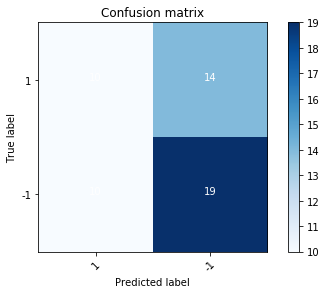

In [548]:
svc_matrix = confusion_matrix(y_test, logi.predict(X_test))
plt.figure()
plot_confusion_matrix(svc_matrix, ('1', '-1'))

We can start with a simple model, like SVM for classification

In [537]:
tuned_parameters = {'kernel': ['rbf'], 'gamma': [1e-3, 1e-4],
                     'C': [1, 10, 100, 1000],
                   'class_weight' : ['', 'balanced']}
                   

In [538]:
scores = ['precision', 'recall']

In [539]:
for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print()

    clf = GridSearchCV(SVC(), tuned_parameters, cv=5,
                       scoring='%s_macro' % score)
    clf.fit(X_train, y_train)

    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
    print()

    print("Detailed classification report:")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
    y_true, y_pred = y_test, clf.predict(X_test)
    print(classification_report(y_true, y_pred))
    print()

# Tuning hyper-parameters for precision
()
Best parameters set found on development set:
()
{'kernel': 'rbf', 'C': 1, 'gamma': 0.001, 'class_weight': ''}
()
Grid scores on development set:
()
0.406 (+/-0.123) for {'kernel': 'rbf', 'C': 1, 'gamma': 0.001, 'class_weight': ''}
0.378 (+/-0.311) for {'kernel': 'rbf', 'C': 1, 'gamma': 0.0001, 'class_weight': ''}
0.395 (+/-0.094) for {'kernel': 'rbf', 'C': 1, 'gamma': 0.001, 'class_weight': 'balanced'}
0.390 (+/-0.113) for {'kernel': 'rbf', 'C': 1, 'gamma': 0.0001, 'class_weight': 'balanced'}
0.362 (+/-0.175) for {'kernel': 'rbf', 'C': 10, 'gamma': 0.001, 'class_weight': ''}
0.400 (+/-0.249) for {'kernel': 'rbf', 'C': 10, 'gamma': 0.0001, 'class_weight': ''}
0.379 (+/-0.096) for {'kernel': 'rbf', 'C': 10, 'gamma': 0.001, 'class_weight': 'balanced'}
0.362 (+/-0.108) for {'kernel': 'rbf', 'C': 10, 'gamma': 0.0001, 'class_weight': 'balanced'}
0.346 (+/-0.044) for {'kernel': 'rbf', 'C': 100, 'gamma': 0.001, 'class_weight': ''}
0.395 (+/-0.084) fo

In [540]:
svc = SVC(C=1, gamma=0.001)
svc.fit(X_train, y_train)

SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.001, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [541]:
svc_matrix = confusion_matrix(y_test, svc.predict(X_test))
svc_matrix

array([[12, 16,  0],
       [ 4, 47,  3],
       [ 2, 20,  2]], dtype=int64)

Confusion matrix, without normalization
[[12 16  0]
 [ 4 47  3]
 [ 2 20  2]]


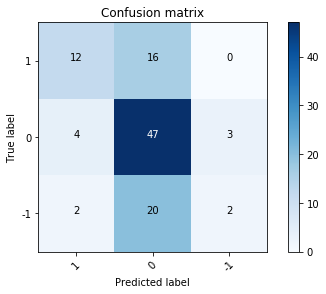

In [542]:
plt.figure()
plot_confusion_matrix(svc_matrix, ('1', '0', '-1'))

Class 0 over-represented

## Random Forest

In [524]:
tuned_parameters = {'n_estimators': [1, 10, 100, 1000]}

In [525]:
for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print()

    clf = GridSearchCV(RandomForestClassifier(), tuned_parameters, cv=5,
                       scoring='%s_macro' % score)
    clf.fit(X_train, y_train)

    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
    print()

    print("Detailed classification report:")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
    y_true, y_pred = y_test, clf.predict(X_test)
    print(classification_report(y_true, y_pred))
    print()

# Tuning hyper-parameters for precision
()
Best parameters set found on development set:
()
{'n_estimators': 100}
()
Grid scores on development set:
()
0.360 (+/-0.114) for {'n_estimators': 1}
0.379 (+/-0.158) for {'n_estimators': 10}
0.465 (+/-0.179) for {'n_estimators': 100}
0.457 (+/-0.095) for {'n_estimators': 1000}
()
Detailed classification report:
()
The model is trained on the full development set.
The scores are computed on the full evaluation set.
()
             precision    recall  f1-score   support

         -1       0.39      0.39      0.39        23
          0       0.66      0.81      0.73        58
          1       0.33      0.16      0.22        25

avg / total       0.53      0.57      0.53       106

()
# Tuning hyper-parameters for recall
()
Best parameters set found on development set:
()
{'n_estimators': 100}
()
Grid scores on development set:
()
0.382 (+/-0.131) for {'n_estimators': 1}
0.419 (+/-0.149) for {'n_estimators': 10}
0.426 (+/-0.041) for {'n_estimat

In [526]:
forest = RandomForestClassifier(n_estimators=100, n_jobs=-1)
forest.fit(X_train, y_train)
forest.score(X_test,y_test)

0.53773584905660377

In [527]:
svc_matrix = confusion_matrix(y_test, forest.predict(X_test))
svc_matrix

array([[ 8, 13,  2],
       [ 6, 48,  4],
       [ 6, 18,  1]], dtype=int64)

Confusion matrix, without normalization
[[ 8 13  2]
 [ 6 48  4]
 [ 6 18  1]]


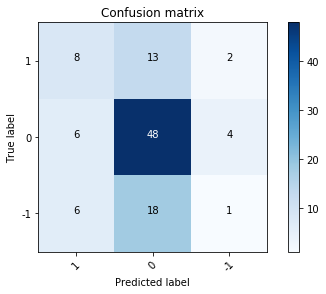

In [528]:
plt.figure()
plot_confusion_matrix(svc_matrix, ('1', '0', '-1'))

We can try a neural netork as well like MLP

In [505]:
mlp = MLPClassifier(activation='relu', solver='adam', random_state=0)
mlp.fit(X_train, y_train)

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=0, shuffle=True,
       solver='adam', tol=0.0001, validation_fraction=0.1, verbose=False,
       warm_start=False)

Confusion matrix, without normalization
[[ 7 13  1]
 [ 7 49  1]
 [ 3 24  1]]


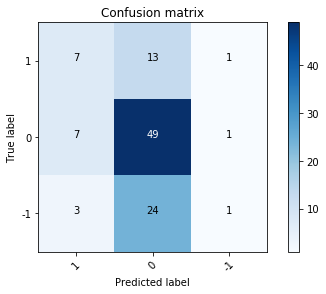

In [506]:
svc_matrix = confusion_matrix(y_test, mlp.predict(X_test))
plt.figure()
plot_confusion_matrix(svc_matrix, ('1', '0', '-1'))

In [321]:
mlp.predict(X_test)

array([-1,  0,  0,  1,  0, -1,  1,  0,  1,  0,  0,  0, -1,  0,  1,  0,  0,
        0, -1,  0,  0,  0,  0,  0,  0, -1,  0, -1,  1,  0,  1,  0,  1,  0,
        0,  0,  0,  1,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0, -1,  0, -1,
        0,  0,  0,  0,  1,  0,  0,  0,  0, -1,  1,  0,  1,  0,  0,  1,  1,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, -1,  0,
        1,  1,  0,  0, -1,  1, -1,  0,  0,  0, -1,  0,  1,  0,  0,  0,  0,
        0,  0,  0, -1], dtype=int64)

In [450]:
mlp.score(X_test, y_test)

0.38202247191011235

In [451]:
corr_mat = sales_surrounding.corr().Performance.to_frame()
corr_mat.columns = ['Correlation']
corr_mat['Correlation_abs'] = abs(corr_mat.Correlation)
corr_mat = corr_mat.sort_values('Correlation_abs', ascending=False).drop('Correlation_abs', axis=1).copy()

In [452]:
corr_mat

,Correlation
Performance,1.000000
surroundings.electronics_store,-0.141159
surroundings.meal_takeaway,-0.135743
surroundings.transit_station,-0.135421
surroundings.bus_station,-0.134495
surroundings.post_office,-0.130106
surroundings.travel_agency,-0.127645
surroundings.store,-0.127191
surroundings.accounting,-0.121846
surroundings.cafe,-0.120690


# Visualization

In [92]:
sales_surrounding = sales_perf.join(count, how='inner')

In [93]:
sales_surrounding.head()

,Mean_Perf,Median_Perf,Performance,surroundings.accounting,surroundings.airport,surroundings.amusement_park,surroundings.aquarium,surroundings.art_gallery,surroundings.atm,surroundings.bakery,...,surroundings.train_station,surroundings.transit_station,surroundings.travel_agency,surroundings.university,surroundings.veterinary_care,surroundings.zoo,summation,latitude,longitude,close_POS
store_code,,,,,,,,,,,,,,,,,,,,,
10055,0.0,30.0,1,3,0,0,0,1,1,3,...,0,2,1,0,1,0,168,46.195035,6.192835,False
10077,0.0,30.0,1,0,0,0,0,0,0,1,...,0,1,0,0,0,0,18,46.205011,6.201729,False
10079,0.0,30.0,1,1,0,0,0,0,3,3,...,0,4,2,0,0,0,191,46.779259,6.635920,False
10086,0.0,-30.0,-1,0,0,0,0,0,0,0,...,0,1,0,0,0,0,25,46.540611,6.620909,False
10111,0.0,-30.0,-1,0,0,0,0,0,0,0,...,0,4,0,0,0,0,23,46.769927,6.649702,False


In [94]:
locations = sales_surrounding[['latitude', 'longitude']]

In [95]:
locationlist = locations.values.tolist()

In [96]:
map = folium.Map(location=[46.8, 8.0],zoom_start=8)

for point in range(0, len(locationlist)):
    if sales_surrounding.Performance.iloc[point]:
        folium.Marker(locationlist[point],
                     icon=folium.Icon(color='red', icon='star')).add_to(map)
    else:
        folium.Marker(locationlist[point],
                     icon=folium.Icon(color='blue', icon='minus')).add_to(map)
    
map